<a href="https://colab.research.google.com/github/BearKS/Robotic-weed-control-system/blob/main/Weed_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2 as cv
from matplotlib import pyplot as plt

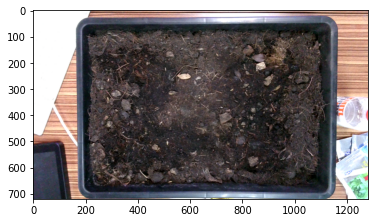

In [ ]:
img = cv.imread('/content/drive/MyDrive/Colab Notebooks/Photo/RWSIP_20220829_153619.png')
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)


dim = (1280, 720)
#resize IMG
resized = cv.resize(img_rgb,dim)

plt.imshow(resized)
plt.show()